In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors.oracle import Oracle

from tda.tracker.filters.linear_kalman import LinearKalman

In [2]:
sim = Simulation()

platform = LTIObject(1, np.array([2, 3, 0]), sim, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, 1.0, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

In [3]:
sim_records = sim.run()

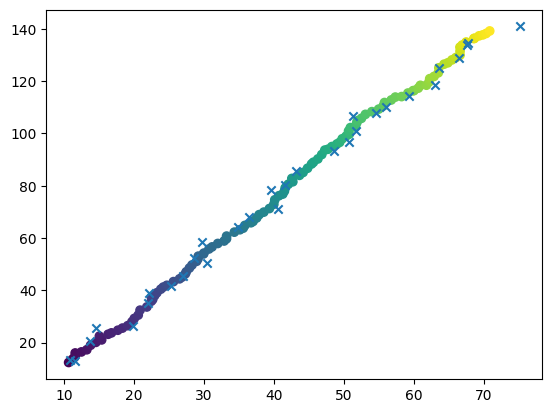

In [4]:
plt.scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], c=sim_records["lti_object2"]["t"])
plt.scatter(sim_records["oracle1"]["target_x"], sim_records["oracle1"]["target_y"], marker="x")

In [5]:
def F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F

def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

H = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

R = 3 * np.eye(3)
#R[0, 0] = R[1, 1] = R[2, 2] = 3

x_hat_0 = np.zeros(6)
P_hat_0 = 1e9 * np.eye(6)

kf = LinearKalman(x_hat_0, P_hat_0, F, H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        kf.update(m)

kf_record = kf.record()

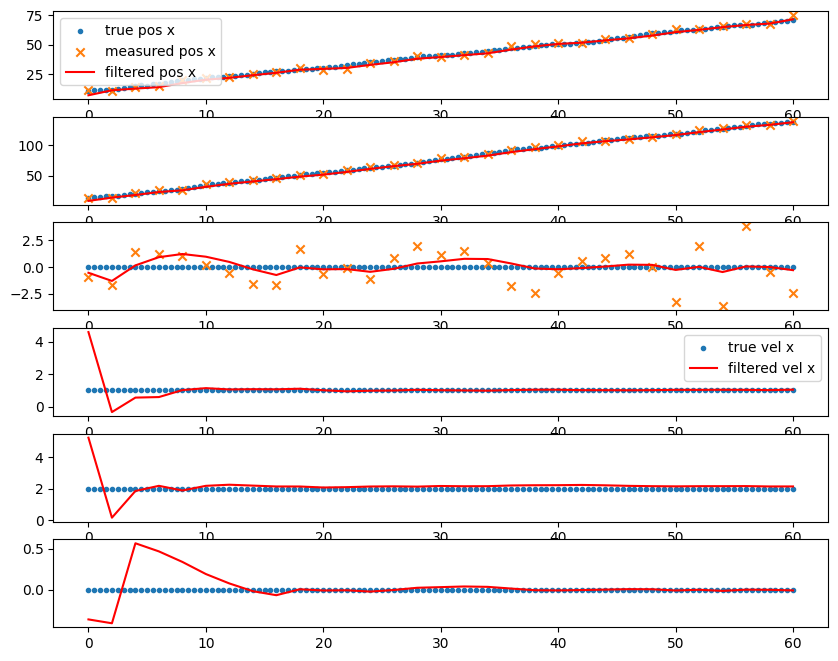

In [6]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")

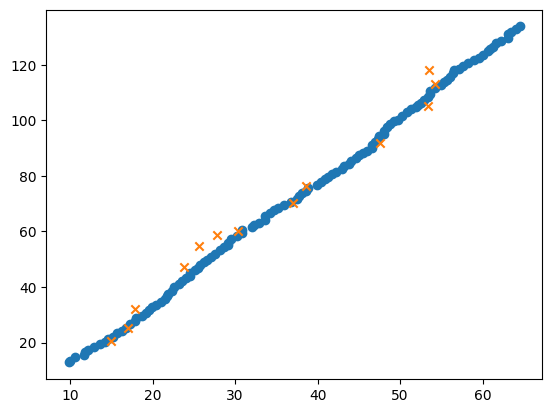

In [7]:
sim2 = Simulation()

platform = LTIObject(1, np.array([2, 3, 0]), sim2, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, 0.5, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.11
target_Q[1, 1] = 0.07

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim2, target_Q)

sim2._sim_objects.extend([platform, target])

sim2_records = sim2.run()

plt.scatter(sim2_records["lti_object2"]["x"], sim2_records["lti_object2"]["y"])
plt.scatter(sim2_records["oracle1"]["target_x"], sim2_records["oracle1"]["target_y"], marker="x")

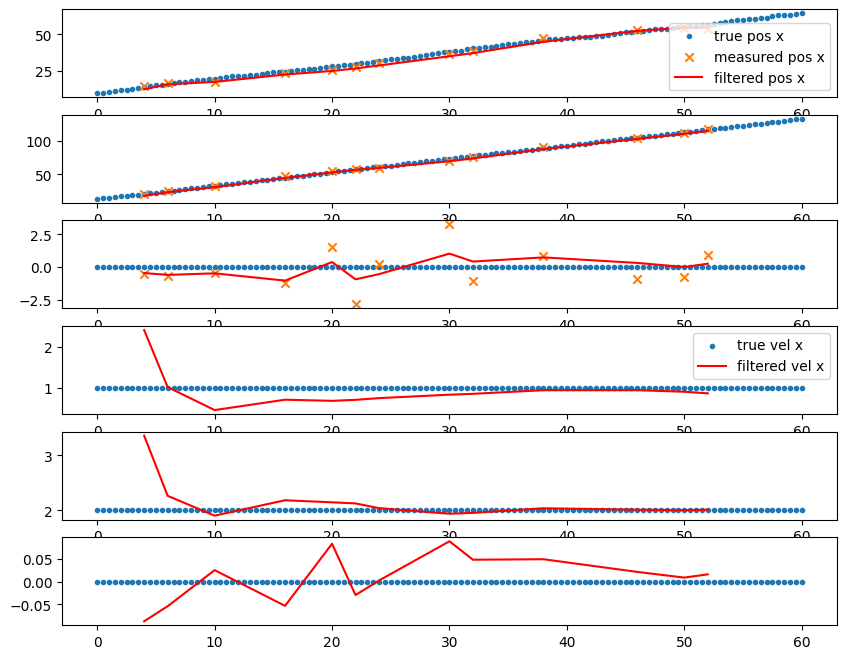

In [8]:
kf2 = LinearKalman(x_hat_0, P_hat_0, F, H, Q, R)

for frame in sim2.meas_queue:
    for m in frame:
        kf2.update(m)

kf2_record = kf2.record()

fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf2_record["t"], kf2_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf2_record["t"], kf2_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf2_record["t"], kf2_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf2_record["t"], kf2_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf2_record["t"], kf2_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf2_record["t"], kf2_record["x_hat"][:, 5], color="red", label="filtered pos z")

In [10]:
sim3 = Simulation()

platform = LTIObject(1, np.array([2, 3, 0]), sim3, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, 1.0, np.eye(3) * 2.25)
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim3, target_Q)
target2 = LTIObject(3, np.array([2, 88, 0, 1, -1, 0]), sim3, target_Q)


sim3._sim_objects.extend([platform, target, target2])

sim3_records = sim3.run()

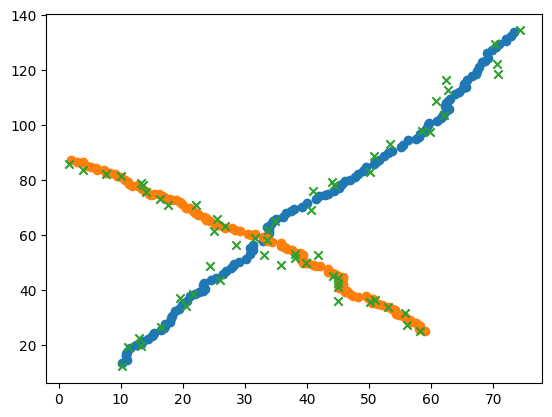

In [11]:
plt.scatter(sim3_records["lti_object2"]["x"], sim3_records["lti_object2"]["y"])
#target2 = np.where(sim2_records["oracle1"]["target_id"] == 2)
#plt.scatter(sim_records["oracle1"]["target_x"][target2], sim_records["oracle1"]["target_y"][target2], marker="x")
plt.scatter(sim3_records["lti_object3"]["x"], sim3_records["lti_object3"]["y"])
#target3 = sim2_records["oracle1"]["target_id"] == 3
plt.scatter(sim3_records["oracle1"]["target_x"], sim3_records["oracle1"]["target_y"], marker="x")